In [1]:
"""
Caleb Ellington
C-NOTEARS hack
10/2/20

This is a proof-of-concept for the contextualized no-tears method.
A list of all the bad design choices is kept below
==================================================

- batchsize limited to 1, 
- Subtype expression sample (X_n) must have the same shape as subtype
    network (W_n) to work with rigid model.fit input definitions
"""

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import utils
utils.set_random_seed(1)

/Users/calebellington/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


subtypes (200, 2), W_n (200, 6, 6), e_n (200, 20, 1), X_n (200, 6, 6)
true 0


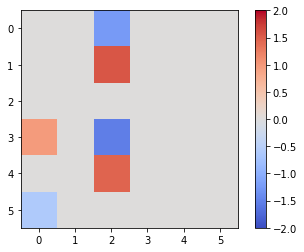

true 1


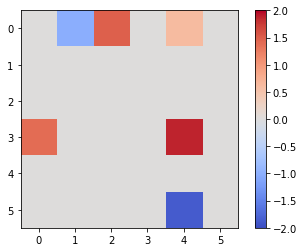

In [64]:
# Generate synthetic data and load the outputs
!python dataloader.py

archz = np.load('outputs/archetypes.npz')
W_k = archz['W_k']  # True network archetypes
e_k = archz['e_k']  # True epigenetic archetypes
samplez = np.load('outputs/samples.npz')
subtypes = samplez['subtypes']
W_n = samplez['W_n']  # Subtype network parameters
e_n = samplez['e_n'][:,:,np.newaxis]  # Subtype epigenetic profile
X_n = samplez['X_n']  # Subtype network expression data 

# Print data shapes and visualize true archetypes
print(f"subtypes {subtypes.shape}, W_n {W_n.shape}, e_n {e_n.shape}, X_n {X_n.shape}")
for i in range(k):
    print(f"true archetype {i}")
    plt.imshow(W_k[i], cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar()
    plt.show()

In [65]:
# Model definitions
n, d, _ = W_n.shape
xn = X_n.shape[1]
cn = e_n.shape[1]
k = subtypes.shape[1]  # Learned archetype dictionary size
batch_size = 1
epochs = 100
encoder_input_shape = (cn, 1)
encoder_output_shape = (k,)
dict_output_shape = (d, d)
tf_dtype = tf.dtypes.float32

print(f"n {n}, d {d}, xn {xn}, cn {cn}, k {k}")

n 200, d 6, xn 6, cn 20, k 2


In [92]:
# Constructing the model

# CEN context variable input
context = tf.keras.layers.Input(
    shape=encoder_input_shape, dtype=tf_dtype, name="C"
)

# Encoder: context --> subtype
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(np.prod(encoder_output_shape), activation='softmax'),
])
encodings = encoder(context, name="E")

# Define the Explainer layer
class Explainer(tf.keras.layers.Layer):
    def __init__(self, archetype_shape):
        # Define the trainable archetype dictionary
        super(Explainer, self).__init__()
        self.archetypes = self.add_weight("archetypes", 
                                          shape=archetype_shape)
        self.k, self.d, _ = archetype_shape
        
    def build(self, input_shapes):
        pass
        
    def call(self, subtype):
        # Output a subtype linear combination of the archetype dictionary
        tiled = tf.tile(subtype, (self.d*self.d, 1))
        transposed = tf.transpose(tiled)
        weights = tf.reshape(transposed, (subtype.shape[1], self.d, self.d))
        result = tf.math.reduce_sum(tf.math.multiply(weights, self.archetypes), axis=0)
        return result

# Link the encoder and explainer and define the model
explainer = Explainer(W_k.shape)
outputs = explainer(encodings)
model = tf.keras.models.Model(inputs=context, outputs=outputs)

# Define NO-TEARS loss
def loss(x_true, w_pred):
    # TODO: ALL HYPERPARAMETERS ARE GUESSED FOR THIS TOY EXAMPLE
    # Based on https://github.com/ignavier/notears-tensorflow
    d = float(tf.shape(w_pred)[1])
    n = float(tf.shape(x_true)[0])
    l1_lambda = 1.0e-1
    alpha = 1.0e2
    rho = 1.0e1
    h = tf.linalg.trace(tf.linalg.expm(w_pred * w_pred)) - d
    x_prime = tf.matmul(x_true, w_pred)
    mse = tf.square(tf.linalg.norm(x_true - x_prime))
    return 0.5 / n * mse \
            + l1_lambda * tf.norm(w_pred, ord=1) \
            + alpha * h + 0.5 * rho * h * h

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
metrics = ['accuracy']
model.compile(loss=loss, 
             optimizer=opt, 
             metrics = metrics)

In [93]:
# Fit the model to the training subtypes (C input, X measured expression reference)
model.fit(e_n[:180], X_n[:180], batch_size=batch_size, epochs=epochs)

Epoch 1/100
180/180 [==============================] - 0s 870us/step - loss: 28.5227 - accuracy: 0.2176
Epoch 2/100
180/180 [==============================] - 0s 915us/step - loss: 24.0228 - accuracy: 0.2204
Epoch 3/100
180/180 [==============================] - 0s 899us/step - loss: 23.3528 - accuracy: 0.2343
Epoch 4/100
180/180 [==============================] - 0s 890us/step - loss: 22.7585 - accuracy: 0.2074
Epoch 5/100
180/180 [==============================] - 0s 938us/step - loss: 20.3959 - accuracy: 0.2204
Epoch 6/100
180/180 [==============================] - 0s 905us/step - loss: 18.5741 - accuracy: 0.2194
Epoch 7/100
180/180 [==============================] - 0s 852us/step - loss: 18.1303 - accuracy: 0.2046
Epoch 8/100
180/180 [==============================] - 0s 893us/step - loss: 17.8965 - accuracy: 0.2083
Epoch 9/100
180/180 [==============================] - 0s 891us/step - loss: 18.1055 - accuracy: 0.2074
Epoch 10/100
180/180 [==============================] - 0s 910us

In [122]:
# Check the MSE of some test sample for validation
y_pred = model.predict(e_n[199:200])
y_true = W_n[199:200][0]
print(f"mse| pred: {np.mean(np.sum(np.square(y_pred-y_true)))}, baseline: {np.mean(np.sum(np.square(np.zeros(y_pred.shape)-y_true)))}")

mse| pred: 0.5792672886499586, baseline: 5.315083741493803


In [123]:
# Define a thresholding function for visualizing predictions
def trim_params(w, thres=0.2):
    w_new = np.copy(w)
    w_new[np.abs(w) < thres] = 0
    return w_new

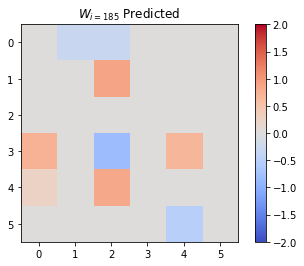

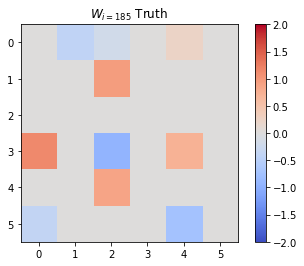

In [124]:
# Visualize a prediction
y_pred = trim_params(y_pred)
plt.imshow(y_pred, cmap='coolwarm', vmin=-2, vmax=2)
plt.title(r"$W_{i=185}$ Predicted")
plt.colorbar()
plt.show()
plt.imshow(y_true, cmap='coolwarm', vmin=-2, vmax=2)
plt.title(r"$W_{i=185}$ Truth")
plt.colorbar()
plt.show()

pred 0


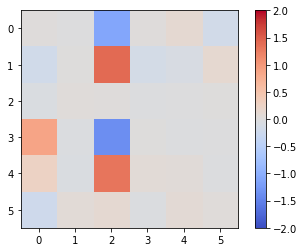

pred 1


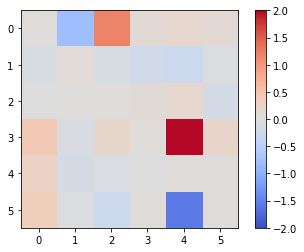

true 0


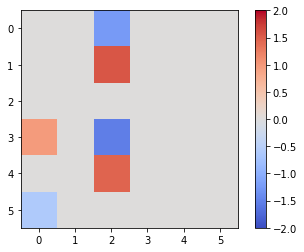

true 1


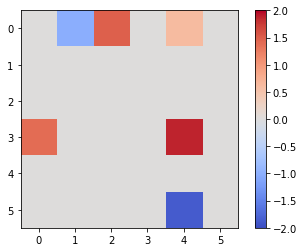

In [121]:
# Visualize the learned archetypes

W_k_pred = explainer.trainable_variables[0].numpy()

for i in range(k):
    print(f"pred {i}")
    plt.imshow(W_k_pred[i], cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar()
    plt.show()
for i in range(k):
    print(f"true {i}")
    plt.imshow(W_k[i], cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar()
    plt.show()

In [125]:
# Display the predicted subtype and real subtype
encoder(e_n[199:200]).numpy(), subtypes[199:200]

(array([[0.64592844, 0.35407162]], dtype=float32),
 array([[0.60978095, 0.39021905]]))